<a href="https://colab.research.google.com/github/devashishk99/CS224n/blob/main/assignments/a1/cs224n_a1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import sys
assert sys.version_info[0]==3
assert sys.version_info[1] >= 5

from gensim.models import KeyedVectors
from gensim.test.utils import datapath
import pprint
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]
import nltk
nltk.download('reuters')
from nltk.corpus import reuters
import numpy as np
import random
import scipy as sp
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA

START_TOKEN = '<START>'
END_TOKEN = '<END>'

np.random.seed(0)
random.seed(0)

[nltk_data] Downloading package reuters to /root/nltk_data...


# Plotting Co-Occurrence Word Embeddings
Here, we will be using the Reuters (business and financial news) corpus. The corpus consists of 10,788 news documents totaling 1.3 million words. These documents span 90 categories and are split into train and test. For more details, please see https://www.nltk.org/book/ch02.html. We provide a read_corpus function below that pulls out only articles from the "crude" (i.e. news articles about oil, gas, etc.) category. The function also adds <START> and <END> tokens to each of the documents, and lowercases words. You do not have to perform any other kind of pre-processing.

In [3]:
def read_corpus(category="crude"):
    """ Read files from the specified Reuter's category.
        Params:
            category (string): category name
        Return:
            list of lists, with words from each of the processed files
    """
    files = reuters.fileids(category)
    return [[START_TOKEN] + [w.lower() for w in list(reuters.words(f))] + [END_TOKEN] for f in files]

In [4]:
reuters_corpus = read_corpus()
pprint.pprint(reuters_corpus[:3], compact=True, width=100)

[['<START>', 'japan', 'to', 'revise', 'long', '-', 'term', 'energy', 'demand', 'downwards', 'the',
  'ministry', 'of', 'international', 'trade', 'and', 'industry', '(', 'miti', ')', 'will', 'revise',
  'its', 'long', '-', 'term', 'energy', 'supply', '/', 'demand', 'outlook', 'by', 'august', 'to',
  'meet', 'a', 'forecast', 'downtrend', 'in', 'japanese', 'energy', 'demand', ',', 'ministry',
  'officials', 'said', '.', 'miti', 'is', 'expected', 'to', 'lower', 'the', 'projection', 'for',
  'primary', 'energy', 'supplies', 'in', 'the', 'year', '2000', 'to', '550', 'mln', 'kilolitres',
  '(', 'kl', ')', 'from', '600', 'mln', ',', 'they', 'said', '.', 'the', 'decision', 'follows',
  'the', 'emergence', 'of', 'structural', 'changes', 'in', 'japanese', 'industry', 'following',
  'the', 'rise', 'in', 'the', 'value', 'of', 'the', 'yen', 'and', 'a', 'decline', 'in', 'domestic',
  'electric', 'power', 'demand', '.', 'miti', 'is', 'planning', 'to', 'work', 'out', 'a', 'revised',
  'energy', 'supply

# Question 1.1: Implement distinct_words 
Write a method to work out the distinct words (word types) that occur in the corpus. You can do this with for loops, but it's more efficient to do it with Python list comprehensions. In particular, this may be useful to flatten a list of lists. If you're not familiar with Python list comprehensions in general, here's more information.

Your returned corpus_words should be sorted. You can use python's sorted function for this.

You may find it useful to use Python sets to remove duplicate words.

In [7]:
def distinct_words(corpus):
    """ Determine a list of distinct words for the corpus.
        Params:
            corpus (list of list of strings): corpus of documents
        Return:
            corpus_words (list of strings): sorted list of distinct words across the corpus
            num_corpus_words (integer): number of distinct words across the corpus
    """
    corpus_words = []
    num_corpus_words = -1
    
    # ------------------
    # Write your implementation here.

    corpus_words = sorted(list({w for sent in corpus for w in sent}))
    num_corpus_words = len(corpus_words)
    # ------------------

    return corpus_words, num_corpus_words

In [8]:
# ---------------------
# Run this sanity check
# Note that this not an exhaustive check for correctness.
# ---------------------

# Define toy corpus
test_corpus = ["{} All that glitters isn't gold {}".format(START_TOKEN, END_TOKEN).split(" "), "{} All's well that ends well {}".format(START_TOKEN, END_TOKEN).split(" ")]
test_corpus_words, num_corpus_words = distinct_words(test_corpus)

# Correct answers
ans_test_corpus_words = sorted([START_TOKEN, "All", "ends", "that", "gold", "All's", "glitters", "isn't", "well", END_TOKEN])
ans_num_corpus_words = len(ans_test_corpus_words)

# Test correct number of words
assert(num_corpus_words == ans_num_corpus_words), "Incorrect number of distinct words. Correct: {}. Yours: {}".format(ans_num_corpus_words, num_corpus_words)

# Test correct words
assert (test_corpus_words == ans_test_corpus_words), "Incorrect corpus_words.\nCorrect: {}\nYours:   {}".format(str(ans_test_corpus_words), str(test_corpus_words))

# Print Success
print ("-" * 80)
print("Passed All Tests!")
print ("-" * 80)

--------------------------------------------------------------------------------
Passed All Tests!
--------------------------------------------------------------------------------


# Question 1.2: Implement compute_co_occurrence_matrix
Write a method that constructs a co-occurrence matrix for a certain window-size  𝑛
  (with a default of 4), considering words  𝑛
  before and  𝑛
  after the word in the center of the window. Here, we start to use numpy (np) to represent vectors, matrices, and tensors. If you're not familiar with NumPy, there's a NumPy tutorial in the second half of this cs231n Python NumPy tutorial.

In [25]:
def compute_co_occurrence_matrix(corpus, window_size=4):
    """ Compute co-occurrence matrix for the given corpus and window_size (default of 4).
    
        Note: Each word in a document should be at the center of a window. Words near edges will have a smaller
              number of co-occurring words.
              
              For example, if we take the document "<START> All that glitters is not gold <END>" with window size of 4,
              "All" will co-occur with "<START>", "that", "glitters", "is", and "not".
    
        Params:
            corpus (list of list of strings): corpus of documents
            window_size (int): size of context window
        Return:
            M (a symmetric numpy matrix of shape (number of unique words in the corpus , number of unique words in the corpus)): 
                Co-occurence matrix of word counts. 
                The ordering of the words in the rows/columns should be the same as the ordering of the words given by the distinct_words function.
            word2ind (dict): dictionary that maps word to index (i.e. row/column number) for matrix M.
    """
    words, num_words = distinct_words(corpus)
    M = None
    word2ind = {}
    
    # ------------------
    # Write your implementation here.

    for i, w in enumerate(words):
      word2ind[w] = i

    M = np.zeros((num_words, num_words))
    for sent in corpus:
      for i in range(len(sent)):
        start = i - window_size if i - window_size >= 0 else 0
        end = i + window_size + 1 if i + window_size + 1 < len(sent) else len(sent)
        window = sent[start:end]
        # add window members to M
        for w in window:
          M[word2ind[sent[i]]][word2ind[w]] += 1
        # subtract self which is added twice
        M[word2ind[sent[i]]][word2ind[sent[i]]] -= 1                                                         
    
    # ------------------

    return M, word2ind

In [26]:
# ---------------------
# Run this sanity check
# Note that this is not an exhaustive check for correctness.
# ---------------------

# Define toy corpus and get student's co-occurrence matrix
test_corpus = ["{} All that glitters isn't gold {}".format(START_TOKEN, END_TOKEN).split(" "), "{} All's well that ends well {}".format(START_TOKEN, END_TOKEN).split(" ")]
M_test, word2ind_test = compute_co_occurrence_matrix(test_corpus, window_size=1)

# Correct M and word2ind
M_test_ans = np.array( 
    [[0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,],
     [0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,],
     [0., 1., 0., 0., 0., 0., 0., 0., 1., 0.,],
     [0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,],
     [0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,],
     [0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,],
     [1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,],
     [0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,],
     [0., 0., 1., 0., 1., 1., 0., 0., 0., 1.,],
     [1., 0., 0., 1., 1., 0., 0., 0., 1., 0.,]]
)
ans_test_corpus_words = sorted([START_TOKEN, "All", "ends", "that", "gold", "All's", "glitters", "isn't", "well", END_TOKEN])
word2ind_ans = dict(zip(ans_test_corpus_words, range(len(ans_test_corpus_words))))

# Test correct word2ind
assert (word2ind_ans == word2ind_test), "Your word2ind is incorrect:\nCorrect: {}\nYours: {}".format(word2ind_ans, word2ind_test)

# Test correct M shape
assert (M_test.shape == M_test_ans.shape), "M matrix has incorrect shape.\nCorrect: {}\nYours: {}".format(M_test.shape, M_test_ans.shape)

# Test correct M values
for w1 in word2ind_ans.keys():
    idx1 = word2ind_ans[w1]
    for w2 in word2ind_ans.keys():
        idx2 = word2ind_ans[w2]
        student = M_test[idx1, idx2]
        correct = M_test_ans[idx1, idx2]
        if student != correct:
            print("Correct M:")
            print(M_test_ans)
            print("Your M: ")
            print(M_test)
            raise AssertionError("Incorrect count at index ({}, {})=({}, {}) in matrix M. Yours has {} but should have {}.".format(idx1, idx2, w1, w2, student, correct))

# Print Success
print ("-" * 80)
print("Passed All Tests!")
print ("-" * 80)

--------------------------------------------------------------------------------
Passed All Tests!
--------------------------------------------------------------------------------


# Question 1.3: Implement reduce_to_k_dim 
Construct a method that performs dimensionality reduction on the matrix to produce k-dimensional embeddings. Use SVD to take the top k components and produce a new matrix of k-dimensional embeddings.

Note: All of numpy, scipy, and scikit-learn (sklearn) provide some implementation of SVD, but only scipy and sklearn provide an implementation of Truncated SVD, and only sklearn provides an efficient randomized algorithm for calculating large-scale Truncated SVD. So please use sklearn.decomposition.TruncatedSVD.

In [31]:
def reduce_to_k_dim(M, k=2):
    """ Reduce a co-occurence count matrix of dimensionality (num_corpus_words, num_corpus_words)
        to a matrix of dimensionality (num_corpus_words, k) using the following SVD function from Scikit-Learn:
            - http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html
    
        Params:
            M (numpy matrix of shape (number of unique words in the corpus , number of unique words in the corpus)): co-occurence matrix of word counts
            k (int): embedding size of each word after dimension reduction
        Return:
            M_reduced (numpy matrix of shape (number of corpus words, k)): matrix of k-dimensioal word embeddings.
                    In terms of the SVD from math class, this actually returns U * S
    """    
    n_iters = 10     # Use this parameter in your call to `TruncatedSVD`
    M_reduced = None
    print("Running Truncated SVD over %i words..." % (M.shape[0]))
    
    # ------------------
    # Write your implementation here.

    svd = TruncatedSVD(n_components=k)
    M_reduced = svd.fit_transform(M)

    # ------------------

    print("Done.")
    return M_reduced

In [32]:
# ---------------------
# Run this sanity check
# Note that this is not an exhaustive check for correctness 
# In fact we only check that your M_reduced has the right dimensions.
# ---------------------

# Define toy corpus and run student code
test_corpus = ["{} All that glitters isn't gold {}".format(START_TOKEN, END_TOKEN).split(" "), "{} All's well that ends well {}".format(START_TOKEN, END_TOKEN).split(" ")]
M_test, word2ind_test = compute_co_occurrence_matrix(test_corpus, window_size=1)
M_test_reduced = reduce_to_k_dim(M_test, k=2)

# Test proper dimensions
assert (M_test_reduced.shape[0] == 10), "M_reduced has {} rows; should have {}".format(M_test_reduced.shape[0], 10)
assert (M_test_reduced.shape[1] == 2), "M_reduced has {} columns; should have {}".format(M_test_reduced.shape[1], 2)

# Print Success
print ("-" * 80)
print("Passed All Tests!")
print ("-" * 80)

Running Truncated SVD over 10 words...
Done.
--------------------------------------------------------------------------------
Passed All Tests!
--------------------------------------------------------------------------------


# Question 1.4: Implement plot_embeddings 
Here you will write a function to plot a set of 2D vectors in 2D space. For graphs, we will use Matplotlib (plt).

For this example, you may find it useful to adapt this code. In the future, a good way to make a plot is to look at the Matplotlib gallery, find a plot that looks somewhat like what you want, and adapt the code they give.

In [42]:
def plot_embeddings(M_reduced, word2ind, words):
    """ Plot in a scatterplot the embeddings of the words specified in the list "words".
        NOTE: do not plot all the words listed in M_reduced / word2ind.
        Include a label next to each point.
        
        Params:
            M_reduced (numpy matrix of shape (number of unique words in the corpus , 2)): matrix of 2-dimensioal word embeddings
            word2ind (dict): dictionary that maps word to indices for matrix M
            words (list of strings): words whose embeddings we want to visualize
    """

    # ------------------
    # Write your implementation here.

    for word in words:
      x = M_reduced[word2ind[word]][0]
      y = M_reduced[word2ind[word]][1]
      plt.scatter(x, y, marker='x', color='red')
      plt.text(x, y, word, fontsize=9)
    plt.show()

    # ------------------

--------------------------------------------------------------------------------
Outputted Plot:


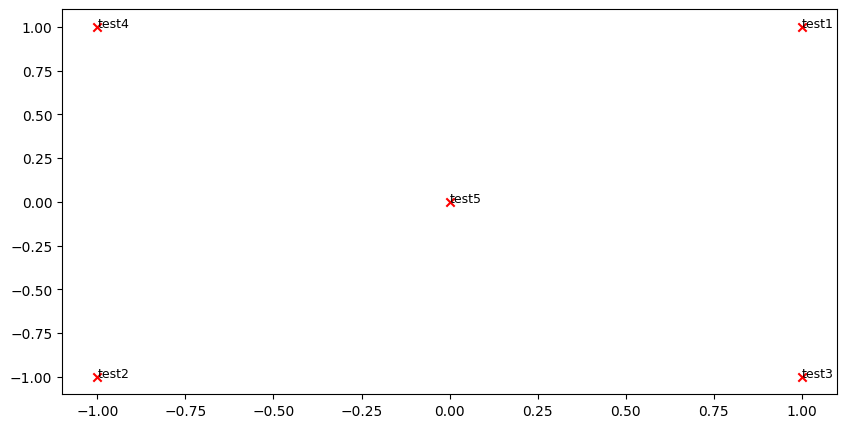

--------------------------------------------------------------------------------


In [43]:
# ---------------------
# Run this sanity check
# Note that this is not an exhaustive check for correctness.
# The plot produced should look like the "test solution plot" depicted below. 
# ---------------------

print ("-" * 80)
print ("Outputted Plot:")

M_reduced_plot_test = np.array([[1, 1], [-1, -1], [1, -1], [-1, 1], [0, 0]])
word2ind_plot_test = {'test1': 0, 'test2': 1, 'test3': 2, 'test4': 3, 'test5': 4}
words = ['test1', 'test2', 'test3', 'test4', 'test5']
plot_embeddings(M_reduced_plot_test, word2ind_plot_test, words)

print ("-" * 80)

# Question 1.5: Co-Occurrence Plot Analysis 
Now we will put together all the parts you have written! We will compute the co-occurrence matrix with fixed window of 4 (the default window size), over the Reuters "crude" (oil) corpus. Then we will use TruncatedSVD to compute 2-dimensional embeddings of each word. TruncatedSVD returns U*S, so we need to normalize the returned vectors, so that all the vectors will appear around the unit circle (therefore closeness is directional closeness). Note: The line of code below that does the normalizing uses the NumPy concept of broadcasting. If you don't know about broadcasting, check out Computation on Arrays: Broadcasting by Jake VanderPlas.

Run the below cell to produce the plot. It'll probably take a few seconds to run. What clusters together in 2-dimensional embedding space? What doesn't cluster together that you might think should have? Note: "bpd" stands for "barrels per day" and is a commonly used abbreviation in crude oil topic articles.

Running Truncated SVD over 8185 words...
Done.


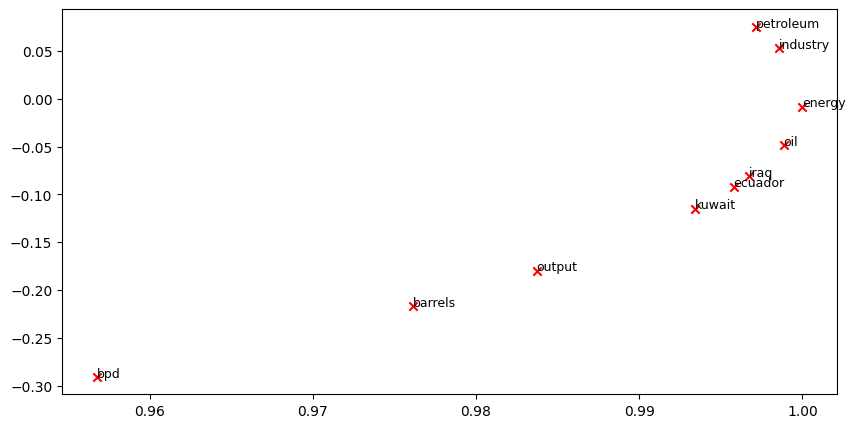

In [44]:
# -----------------------------
# Run This Cell to Produce Your Plot
# ------------------------------
reuters_corpus = read_corpus()
M_co_occurrence, word2ind_co_occurrence = compute_co_occurrence_matrix(reuters_corpus)
M_reduced_co_occurrence = reduce_to_k_dim(M_co_occurrence, k=2)

# Rescale (normalize) the rows to make them each of unit-length
M_lengths = np.linalg.norm(M_reduced_co_occurrence, axis=1)
M_normalized = M_reduced_co_occurrence / M_lengths[:, np.newaxis] # broadcasting

words = ['barrels', 'bpd', 'ecuador', 'energy', 'industry', 'kuwait', 'oil', 'output', 'petroleum', 'iraq']

plot_embeddings(M_normalized, word2ind_co_occurrence, words)

The physical location of words present in the corpus is captured but the semantic meaning isn't exactly. As countries like Kuwait, Ecuador & Iraq are clustered togther and similarly are *petroleum* & *industry* and *oil* & *energy*. While it fails to cluster bpd and barrels.

# Part 2: Prediction-Based Word Vectors
As discussed in class, more recently prediction-based word vectors have demonstrated better performance, such as word2vec and GloVe (which also utilizes the benefit of counts). Here, we shall explore the embeddings produced by GloVe. Please revisit the class notes and lecture slides for more details on the word2vec and GloVe algorithms. If you're feeling adventurous, challenge yourself and try reading GloVe's original paper.

Then run the following cells to load the GloVe vectors into memory. Note: If this is your first time to run these cells, i.e. download the embedding model, it will take a couple minutes to run. If you've run these cells before, rerunning them will load the model without redownloading it, which will take about 1 to 2 minutes.

In [49]:
def load_embedding_model():
    """ Load GloVe Vectors
        Return:
            wv_from_bin: All 400000 embeddings, each lengh 200
    """
    import gensim.downloader as api
    wv_from_bin = api.load("glove-wiki-gigaword-200")
    print("Loaded vocab size %i" % len(wv_from_bin.key_to_index.keys()))
    return wv_from_bin

In [50]:
# -----------------------------------
# Run Cell to Load Word Vectors
# Note: This will take a couple minutes
# -----------------------------------
wv_from_bin = load_embedding_model()

Loaded vocab size 400000


# Reducing dimensionality of Word Embeddings
Let's directly compare the GloVe embeddings to those of the co-occurrence matrix. In order to avoid running out of memory, we will work with a sample of 10000 GloVe vectors instead. Run the following cells to:




1.   Put 10000 Glove vectors into a matrix M
2.   Run reduce_to_k_dim (your Truncated SVD function) to reduce the vectors from 200-dimensional to 2-dimensional.



In [54]:
def get_matrix_of_vectors(wv_from_bin, required_words=['barrels', 'bpd', 'ecuador', 'energy', 'industry', 'kuwait', 'oil', 'output', 'petroleum', 'iraq']):
    """ Put the GloVe vectors into a matrix M.
        Param:
            wv_from_bin: KeyedVectors object; the 400000 GloVe vectors loaded from file
        Return:
            M: numpy matrix shape (num words, 200) containing the vectors
            word2ind: dictionary mapping each word to its row number in M
    """
    import random
    words = list(wv_from_bin.key_to_index.keys())
    print("Shuffling words ...")
    random.seed(224)
    random.shuffle(words)
    words = words[:10000]
    print("Putting %i words into word2ind and matrix M..." % len(words))
    word2ind = {}
    M = []
    curInd = 0
    for w in words:
        try:
            M.append(wv_from_bin.get_vector(w))
            word2ind[w] = curInd
            curInd += 1
        except KeyError:
            continue
    for w in required_words:
        if w in words:
            continue
        try:
            M.append(wv_from_bin.get_vector(w))
            word2ind[w] = curInd
            curInd += 1
        except KeyError:
            continue
    M = np.stack(M)
    print("Done.")
    return M, word2ind

In [55]:
# -----------------------------------------------------------------
# Run Cell to Reduce 200-Dimensional Word Embeddings to k Dimensions
# Note: This should be quick to run
# -----------------------------------------------------------------
M, word2ind = get_matrix_of_vectors(wv_from_bin)
M_reduced = reduce_to_k_dim(M, k=2)

# Rescale (normalize) the rows to make them each of unit-length
M_lengths = np.linalg.norm(M_reduced, axis=1)
M_reduced_normalized = M_reduced / M_lengths[:, np.newaxis] # broadcasting

Shuffling words ...
Putting 10000 words into word2ind and matrix M...
Done.
Running Truncated SVD over 10010 words...
Done.


# Question 2.1: GloVe Plot Analysis 
Run the cell below to plot the 2D GloVe embeddings for ['barrels', 'bpd', 'ecuador', 'energy', 'industry', 'kuwait', 'oil', 'output', 'petroleum', 'iraq'].

What clusters together in 2-dimensional embedding space? What doesn't cluster together that you think should have? How is the plot different from the one generated earlier from the co-occurrence matrix? What is a possible cause for the difference?

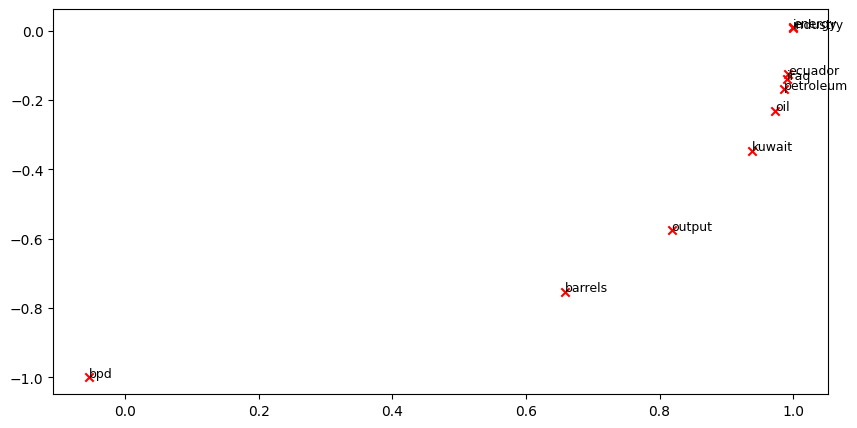

In [56]:
words = ['barrels', 'bpd', 'ecuador', 'energy', 'industry', 'kuwait', 'oil', 'output', 'petroleum', 'iraq']
plot_embeddings(M_reduced_normalized, word2ind, words)

The clustering is very similar to that of the previous co-occurence matrix with window size 4 with some minor differences


# Question 2.2: Words with Multiple Meanings 
Polysemes and homonyms are words that have more than one meaning (see this wiki page to learn more about the difference between polysemes and homonyms ). Find a word with at least two different meanings such that the top-10 most similar words (according to cosine similarity) contain related words from both meanings. For example, "leaves" has both "go_away" and "a_structure_of_a_plant" meaning in the top 10, and "scoop" has both "handed_waffle_cone" and "lowdown". You will probably need to try several polysemous or homonymic words before you find one.

Please state the word you discover and the multiple meanings that occur in the top 10. Why do you think many of the polysemous or homonymic words you tried didn't work (i.e. the top-10 most similar words only contain one of the meanings of the words)?

Note: You should use the wv_from_bin.most_similar(word) function to get the top 10 similar words. This function ranks all other words in the vocabulary with respect to their cosine similarity to the given word. For further assistance, please check the GenSim documentation.

In [57]:
wv_from_bin.most_similar("plant")

[('plants', 0.8802077174186707),
 ('factory', 0.6054627299308777),
 ('facility', 0.556488573551178),
 ('produce', 0.5439175367355347),
 ('production', 0.5205835103988647),
 ('chemical', 0.5185851454734802),
 ('producing', 0.5161451101303101),
 ('waste', 0.5101147890090942),
 ('factories', 0.506610631942749),
 ('flowering', 0.5009768009185791)]

In [58]:
wv_from_bin.most_similar("book")

[('books', 0.8452467918395996),
 ('author', 0.7746455669403076),
 ('novel', 0.7485204935073853),
 ('published', 0.7451642751693726),
 ('memoir', 0.7047821283340454),
 ('wrote', 0.6971326470375061),
 ('written', 0.6967507004737854),
 ('essay', 0.6844283938407898),
 ('biography', 0.681260347366333),
 ('autobiography', 0.6770558953285217)]

In [59]:
wv_from_bin.most_similar("bat")

[('bats', 0.691724419593811),
 ('batting', 0.6160588264465332),
 ('balls', 0.5692734122276306),
 ('batted', 0.5530908107757568),
 ('toss', 0.5506128668785095),
 ('wicket', 0.5495278835296631),
 ('pitch', 0.5489361882209778),
 ('bowled', 0.5452010631561279),
 ('hitter', 0.5353438854217529),
 ('batsman', 0.5348091125488281)]

As there is only 1 vector for every word it becomes difficult to store mu;tiple meanings of the word, if any. 

# Question 2.3: Synonyms & Antonyms 
When considering Cosine Similarity, it's often more convenient to think of Cosine Distance, which is simply 1 - Cosine Similarity.

Find three words  (𝑤1,𝑤2,𝑤3)
  where  𝑤1
  and  𝑤2
  are synonyms and  𝑤1
  and  𝑤3
  are antonyms, but Cosine Distance  (𝑤1,𝑤3)<
  Cosine Distance  (𝑤1,𝑤2)
 .

As an example,  𝑤1
 ="happy" is closer to  𝑤3
 ="sad" than to  𝑤2
 ="cheerful". Please find a different example that satisfies the above. Once you have found your example, please give a possible explanation for why this counter-intuitive result may have happened.

You should use the the wv_from_bin.distance(w1, w2) function here in order to compute the cosine distance between two words. Please see the GenSim documentation for further assistance.

In [63]:
w1 = "fast"
w2 = "quick"
w3 = "slow"
d_syn = wv_from_bin.distance(w1, w2)
d_ant = wv_from_bin.distance(w1, w3)
if d_syn > d_ant:
  print(w1+ " is similar to "+ w3 + " than to " + w2)

fast is similar to slow than to quick


This could be due to more co-occurence between antonyms rather than the synonyms

# Question 2.4: Analogies with Word Vectors 
Word vectors have been shown to sometimes exhibit the ability to solve analogies.

As an example, for the analogy "man : king :: woman : x" (read: man is to king as woman is to x), what is x?

In the cell below, we show you how to use word vectors to find x using the most_similar function from the GenSim documentation. The function finds words that are most similar to the words in the positive list and most dissimilar from the words in the negative list (while omitting the input words, which are often the most similar; see this paper). The answer to the analogy will have the highest cosine similarity (largest returned numerical value).

In [64]:
# Run this cell to answer the analogy -- man : king :: woman : x
pprint.pprint(wv_from_bin.most_similar(positive=['woman', 'king'], negative=['man']))

[('queen', 0.6978678107261658),
 ('princess', 0.6081745028495789),
 ('monarch', 0.5889754891395569),
 ('throne', 0.5775108933448792),
 ('prince', 0.5750998258590698),
 ('elizabeth', 0.5463595986366272),
 ('daughter', 0.5399126410484314),
 ('kingdom', 0.5318052768707275),
 ('mother', 0.5168544054031372),
 ('crown', 0.5164473056793213)]


Let  𝑚
 ,  𝑘
 ,  𝑤
 , and  𝑥
  denote the word vectors for man, king, woman, and the answer, respectively. Using only vectors  𝑚
 ,  𝑘
 ,  𝑤
 , and the vector arithmetic operators  +
  and  −
  in your answer, what is the expression in which we are maximizing cosine similarity with  𝑥
 ?

Hint: Recall that word vectors are simply multi-dimensional vectors that represent a word. It might help to draw out a 2D example using arbitrary locations of each vector. Where would man and woman lie in the coordinate plane relative to king and the answer?

Maximize : **k - m + w** 

# Question 2.5: Finding Analogies 
Find an example of analogy that holds according to these vectors (i.e. the intended word is ranked top). In your solution please state the full analogy in the form x:y :: a:b. If you believe the analogy is complicated, explain why the analogy holds in one or two sentences.

In [70]:
pprint.pprint(wv_from_bin.most_similar(positive=['poem', 'writer'], negative=['write']))

[('poet', 0.7060352563858032),
 ('novelist', 0.6144760251045227),
 ('author', 0.5475760102272034),
 ('novel', 0.5336947441101074),
 ('essayist', 0.5267536044120789),
 ('playwright', 0.5065078735351562),
 ('dramatist', 0.5037304759025574),
 ('novella', 0.4833751916885376),
 ('prose', 0.48299333453178406),
 ('poems', 0.482883095741272)]


In [72]:
pprint.pprint(wv_from_bin.most_similar(positive=['hear', 'eyes'], negative=['see']))

[('ears', 0.6174951791763306),
 ('heard', 0.5702270269393921),
 ('cries', 0.5625625252723694),
 ('loud', 0.5521842837333679),
 ('whispers', 0.5480906367301941),
 ('hears', 0.546530544757843),
 ('screams', 0.5461402535438538),
 ('hearing', 0.5460774302482605),
 ('listened', 0.5336284041404724),
 ('tears', 0.5250135660171509)]


# Question 2.6: Incorrect Analogy 
Find an example of analogy that does not hold according to these vectors. In your solution, state the intended analogy in the form x:y :: a:b, and state the (incorrect) value of b according to the word vectors.

In [76]:
pprint.pprint(wv_from_bin.most_similar(positive=['bottom', 'left'], negative=['right']))

[('leaving', 0.5817432999610901),
 ('relegation', 0.52540123462677),
 ('half', 0.4948163330554962),
 ('relegated', 0.48758476972579956),
 ('behind', 0.48195329308509827),
 ('side', 0.4709019064903259),
 ('pile', 0.4684520363807678),
 ('off', 0.464995414018631),
 ('stayed', 0.46476274728775024),
 ('away', 0.46464046835899353)]


# Question 2.7: Guided Analysis of Bias in Word Vectors 
It's important to be cognizant of the biases (gender, race, sexual orientation etc.) implicit in our word embeddings. Bias can be dangerous because it can reinforce stereotypes through applications that employ these models.

Run the cell below, to examine (a) which terms are most similar to "woman" and "worker" and most dissimilar to "man", and (b) which terms are most similar to "man" and "worker" and most dissimilar to "woman". Point out the difference between the list of female-associated words and the list of male-associated words, and explain how it is reflecting gender bias.

In [77]:
# Here `positive` indicates the list of words to be similar to and `negative` indicates the list of words to be
# most dissimilar from.
pprint.pprint(wv_from_bin.most_similar(positive=['woman', 'worker'], negative=['man']))
print()
pprint.pprint(wv_from_bin.most_similar(positive=['man', 'worker'], negative=['woman']))

[('employee', 0.6375863552093506),
 ('workers', 0.6068920493125916),
 ('nurse', 0.5837947130203247),
 ('pregnant', 0.5363885164260864),
 ('mother', 0.5321308970451355),
 ('employer', 0.5127025842666626),
 ('teacher', 0.5099576711654663),
 ('child', 0.5096741318702698),
 ('homemaker', 0.5019454956054688),
 ('nurses', 0.4970572590827942)]

[('workers', 0.611325740814209),
 ('employee', 0.5983108878135681),
 ('working', 0.5615329742431641),
 ('laborer', 0.5442320108413696),
 ('unemployed', 0.536851704120636),
 ('job', 0.5278826355934143),
 ('work', 0.5223963856697083),
 ('mechanic', 0.5088937282562256),
 ('worked', 0.5054520964622498),
 ('factory', 0.4940454363822937)]


We find some gender bias in the above output as woman has terms like *homemaker*, *pregnant*, *mother* associated with it while man has neutral terms like *job, work, unemployed*

# Question 2.8: Independent Analysis of Bias in Word Vectors 
Use the most_similar function to find another case where some bias is exhibited by the vectors. Please briefly explain the example of bias that you discover

In [81]:
pprint.pprint(wv_from_bin.most_similar(positive=['black', 'law'], negative=['white']))
print()
pprint.pprint(wv_from_bin.most_similar(positive=['white', 'law'], negative=['black']))

[('laws', 0.7242485284805298),
 ('legal', 0.5861631035804749),
 ('constitutional', 0.5413321852684021),
 ('civil', 0.5351855158805847),
 ('criminal', 0.5157272219657898),
 ('applies', 0.5011377930641174),
 ('practice', 0.49955645203590393),
 ('act', 0.4986741840839386),
 ('rights', 0.4962421953678131),
 ('amendment', 0.49550095200538635)]

[('laws', 0.7135553359985352),
 ('legislation', 0.6658505797386169),
 ('rules', 0.6399865746498108),
 ('administration', 0.6329683065414429),
 ('legal', 0.6245043277740479),
 ('statute', 0.611416757106781),
 ('regulations', 0.5937445759773254),
 ('bill', 0.5886058807373047),
 ('federal', 0.5877929925918579),
 ('constitutional', 0.5808506608009338)]


The above output shows racial bias

# Question 2.9: Thinking About Bias 
Give one explanation of how bias gets into the word vectors. What is an experiment that you could do to test for or to measure this source of bias?

Bias gets into word vectors through the datasets and documents used.


1.   WEAT (Caliskan et al., 2016) is the most common test of bias in word embedding associations. In brief, it answers the following question: where relatedness is cosine similarity, are target words T1
 more related to attribute words X
 than Y
, relative to target words T2?

  For example, are science-related terms more associated with male attributes and art-related terms with female ones? According to the paper that proposed WEAT, yes, they are.
2.   The relational inner product association (RIPA) of a word w
 with respect to a relation vector b
 is β(w ;b)=⟨w ,b⟩
, where  

    *   S is a non-empty set of ordered word pairs (x,y) that define the association
    *   b is the first principal component of {x −y | (x,y)∈S}

  For example, if you wanted to calculate the genderedness of the word ‘door’, you would: 

  *   Take the first principal component of man−woman,king−queen, etc. Call this b.
  *    Calculate the dot product of b and door



